[2703684.0, 209270.0, 116763.0, 78171.0]
[1694709.0, 447670.0, 447436.0, 447195.0]
[4398393.0, 656940.0, 564199.0, 525366.0]
[[2703684.0, 209270.0]] [[1694709.0, 447670.0]]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TH1F::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Info in <TH1F::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Info in <TH1F::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Info in <TH1F::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge


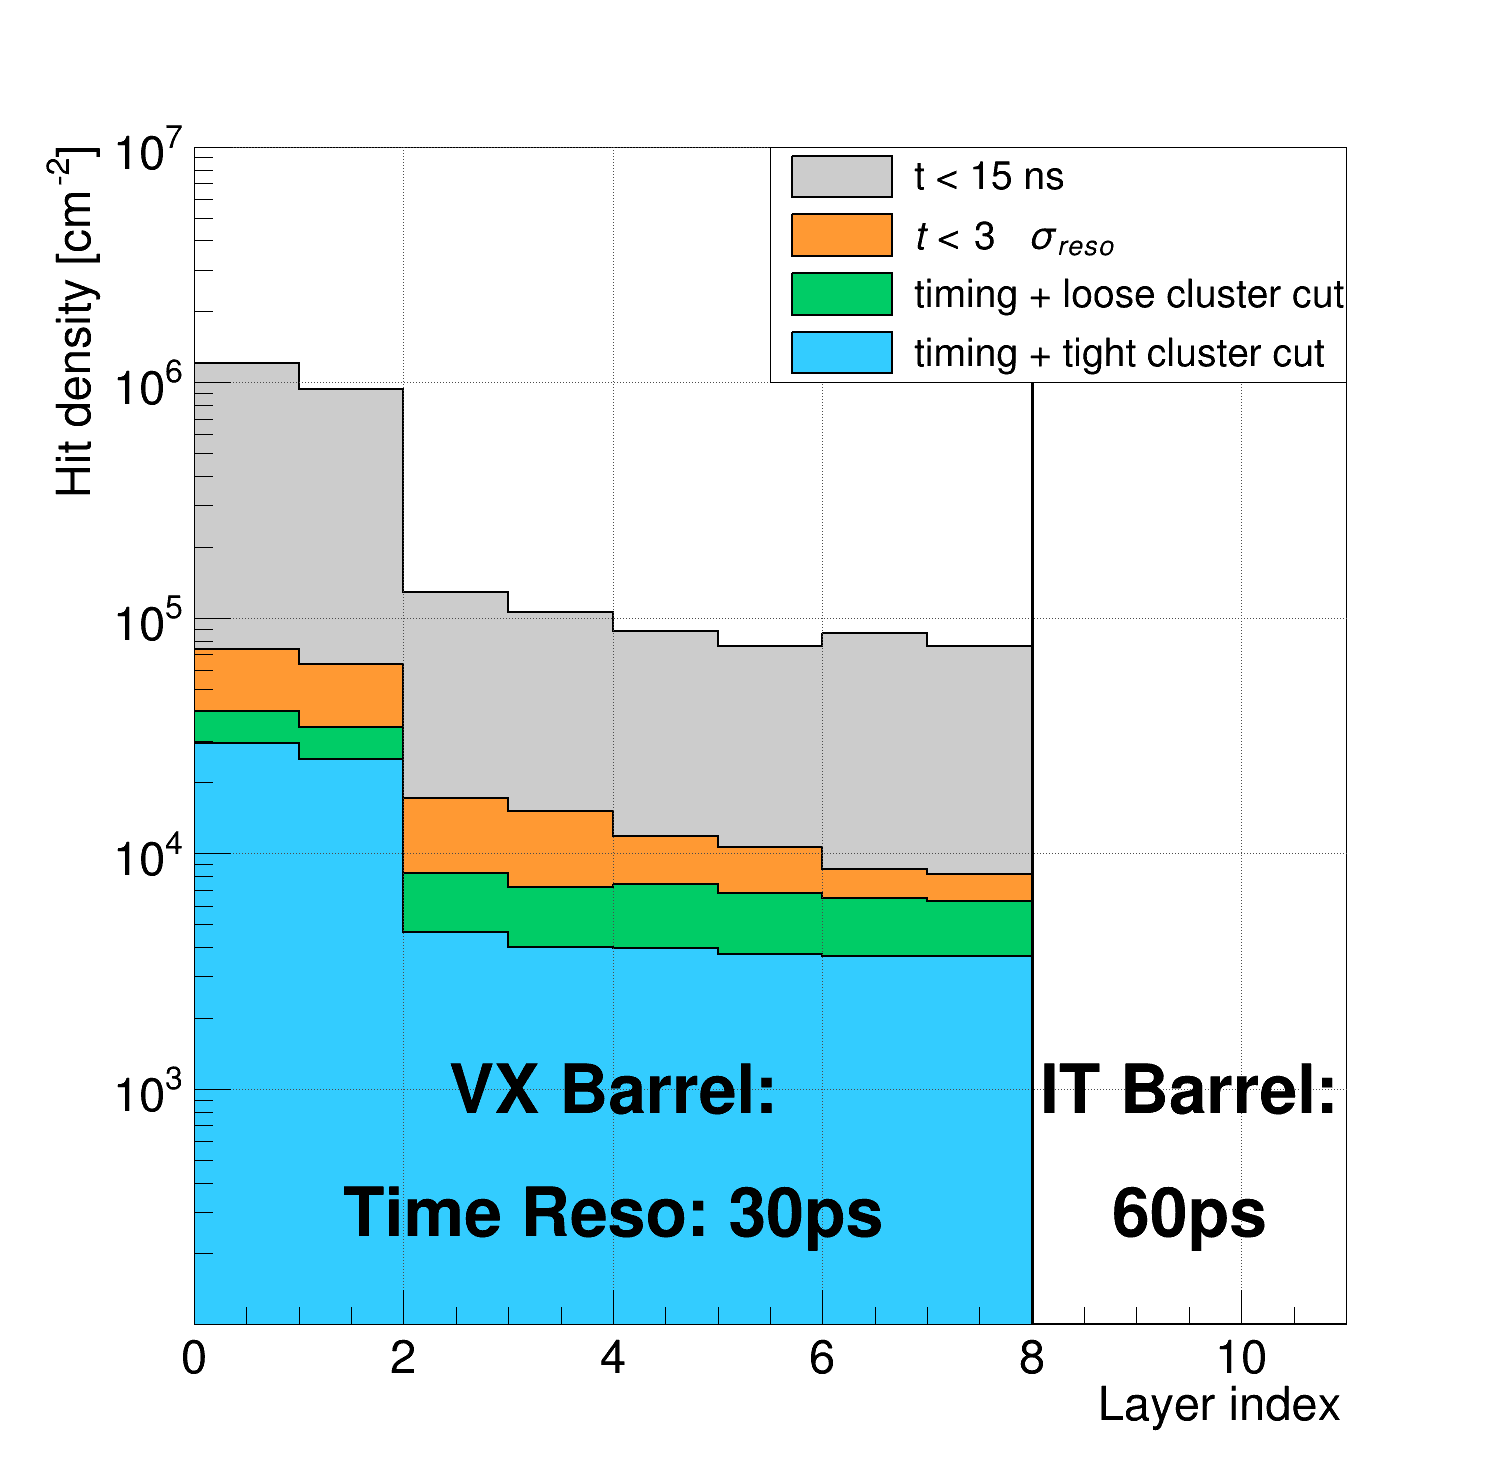

In [10]:
##########################################

# VXDBplots.py
# Imports local data from output root files and extracts contents to create a plot
# June 27, 2023
# Chris Sellgren, UCSB/LBNL/IRIS-HEP

##########################################

import ROOT as R
import math
import os
import numpy as np

R.gStyle.SetOptStat(0)
R.gStyle.SetGridColor(14)
R.gStyle.SetPadRightMargin(0.03)
R.gStyle.SetPadLeftMargin(0.12)

# hard coded values for the sensor layer areas
sens_area = {}
for sub in range(2):
    sens_area.update({('b',l*2+sub): 1e-2*130*a for l, a in enumerate([16*13,15*23,21*24,29*24])})

sens_area_ib = {}
sens_area_ib.update({('b',l): a for l, a in enumerate([8117.85,22034.16,51678.81])})

TIMES = ["30ps","50ps","75ps","100ps","150ps","200ps"]
TIMES = ["30ps"]
TIMES_IT = ["60ps","100ps","150ps","200ps","300ps","400ps"]

vx_tothits = []
it_tothits = []

for iT,time in enumerate(TIMES):
    
    # set canvas
    C = R.TCanvas('canvas','',1500,1500)
    # R.gStyle.SetPalette(R.kBird)
    C.SetLeftMargin(0.13)
    C.SetRightMargin(0.1)
    C.SetGrid(1,1)

    # pull files from local drive
    STUDY_NAME = "originalgeo"
    TIME = time
    TIME_IT = TIMES_IT[iT]
    DIR_IN = '/Users/chris/Desktop/MC/data/myruns_vxdbstudy/' + STUDY_NAME 
    DIR_OUT = '/Users/chris/Desktop/MC/plots/digi_timing_studies'
    NAMES = ['notimingcut','timingcut','loosecluster','tightcluster']
    NAMES = [NAMES[I] + "_"+TIME for I in range(len(NAMES))]
    files_in = [R.TFile(os.path.join(DIR_IN,f'histograms_{n}.root')) for n in NAMES]

    # extract contents from files
    nH = len(NAMES)
    histos_vb = [files_in[i].MyTrackPerf.clusters_vb.numhits_by_layer for i in range(nH)]
    histos_ib = [files_in[i].MyTrackPerf.clusters_ib.numhits_by_layer for i in range(nH)]
    
    # get occupancy data from the histos
    numhits_vx_nocut = 0
    numhits_it_nocut = 0
    numhits_vx_tcut  = 0
    numhits_it_tcut  = 0
    # total hits, vertex
    for l in range(8):
        # no cut
        numhits = histos_vb[0].GetBinContent(l+1)
        numhits_vx_nocut += numhits
        # timing cut
        numhits_cut = histos_vb[1].GetBinContent(l+1)
        numhits_vx_tcut += numhits_cut
    #IT
    for l in range(3): 
        # no cut
        numhits = histos_ib[0].GetBinContent(l+1)
        numhits_it_nocut += numhits
        # timing cut
        numhits_cut = histos_ib[1].GetBinContent(l+1)
        numhits_it_tcut += numhits_cut
    # add to total vectors
    vx_tothits.append([numhits_vx_nocut,numhits_vx_tcut])
    it_tothits.append([numhits_it_nocut,numhits_it_tcut])
    
    # make larger histograms that combine content
    histos = [R.TH1F(f'h{i:d}', ';Layer;Hit density [cm^{-2}]', 16, 0, 16) for i in range(nH)]
    nhits_ib = []
    for i,h in enumerate(histos_ib):
        nhits_ib.append(np.sum([histos_ib[i].GetBinContent(j) for j in range(histos_ib[iH].GetNbinsX())]))
        # noramlize by sensor area, shift bins by 8.
        #for l in range(3):
        #    histos[i].SetBinContent(l+9, h.GetBinContent(l+1))
            #h.SetBinContent(l+1, 0)
    nhits_vx = []
    for iH, h in enumerate(histos_vb):
        h.Draw()
        
        nhits_vx.append(np.sum([histos_vb[iH].GetBinContent(i+1) for i in range(histos_vb[iH].GetNbinsX())]))

        # noramlize by sensor area
        for l in range(8):
            h.SetBinContent(l+9, 0)
            h.SetBinContent(l+1, h.GetBinContent(l+1))

        h.Add(histos[iH])
        
    print(nhits_vx)
    print(nhits_ib)
    print([nhits_vx[i] + nhits_ib[i] for i in range(4)])


    # make plot
    names = [
        't < 15 ns',
        't < 3{$\sigma_{reso}$}',
        'timing + loose cluster cut',
        'timing + tight cluster cut',
    ]

    R.gStyle.SetGridColor(12)
    C.Clear()
    C.cd()
    C.SetGrid(1)

    leg = R.TLegend(0.515, 0.74, 0.9, 0.9)
    colors = [12, R.kAzure+2, R.kPink+2, R.kAzure+7, R.kTeal+2]
    fills = [17,R.kOrange+1, R.kTeal+2, R.kAzure+8] # R.kOrange+1, R.kTeal+2
    # colors = [1, 11, 15]
    # fills = [0, 12, 16]
    yMax = 1e4
    h_ax = R.TH1F('h_ax', ';Layer index;Hit density [cm^{-2}]', 11, 0, 11)
    #h_ax.GetYaxis().SetMaxDigits(4)
    C.SetLogy(True)
    h_ax.SetAxisRange(100, 1e7, 'Y')
    # Optimising the X axis
    a = h_ax.GetXaxis()
    #a.SetNdivisions(-208)
    # Drawing the axes
    h_ax.Draw('AXIS')
    h_ax.Draw('AXIG same')
    # Drawing
    for iT, h in enumerate(histos_vb):
        h.SetLineColor(1)
        h.SetFillColor(fills[iT])
        h.SetLineWidth(2)
        leg_type = 'F'
        leg.AddEntry(h, names[iT], leg_type)
        h.Draw('HIST same')
    h_ax.Draw('AXIG same')
    leg.Draw()
    C.Draw()
    C.RedrawAxis()
    # Drawing text labels
    t1 = R.TText(4, 1000, 'VX Barrel:')
    t3 = R.TText(4, 300, 'Time Reso: '+TIME)
    
    t2 = R.TText(9.5, 1000, 'IT Barrel:')
    t4 = R.TText(9.5, 300, TIME_IT)

    for t in [t1,t2,t3,t4]:
        t.SetTextAlign(22)
        t.SetTextColor(1)
        t.Draw()

    # Drawing vertical separator
    l = R.TLine(8, 0, 8, 1e6)
    l.SetLineWidth(3)
    l.SetLineColor(1)
    l.Draw()
    #C.SaveAs(os.path.join(DIR_OUT,STUDY_NAME+"totalmult_"+TIME+".png"))

print(vx_tothits,it_tothits)

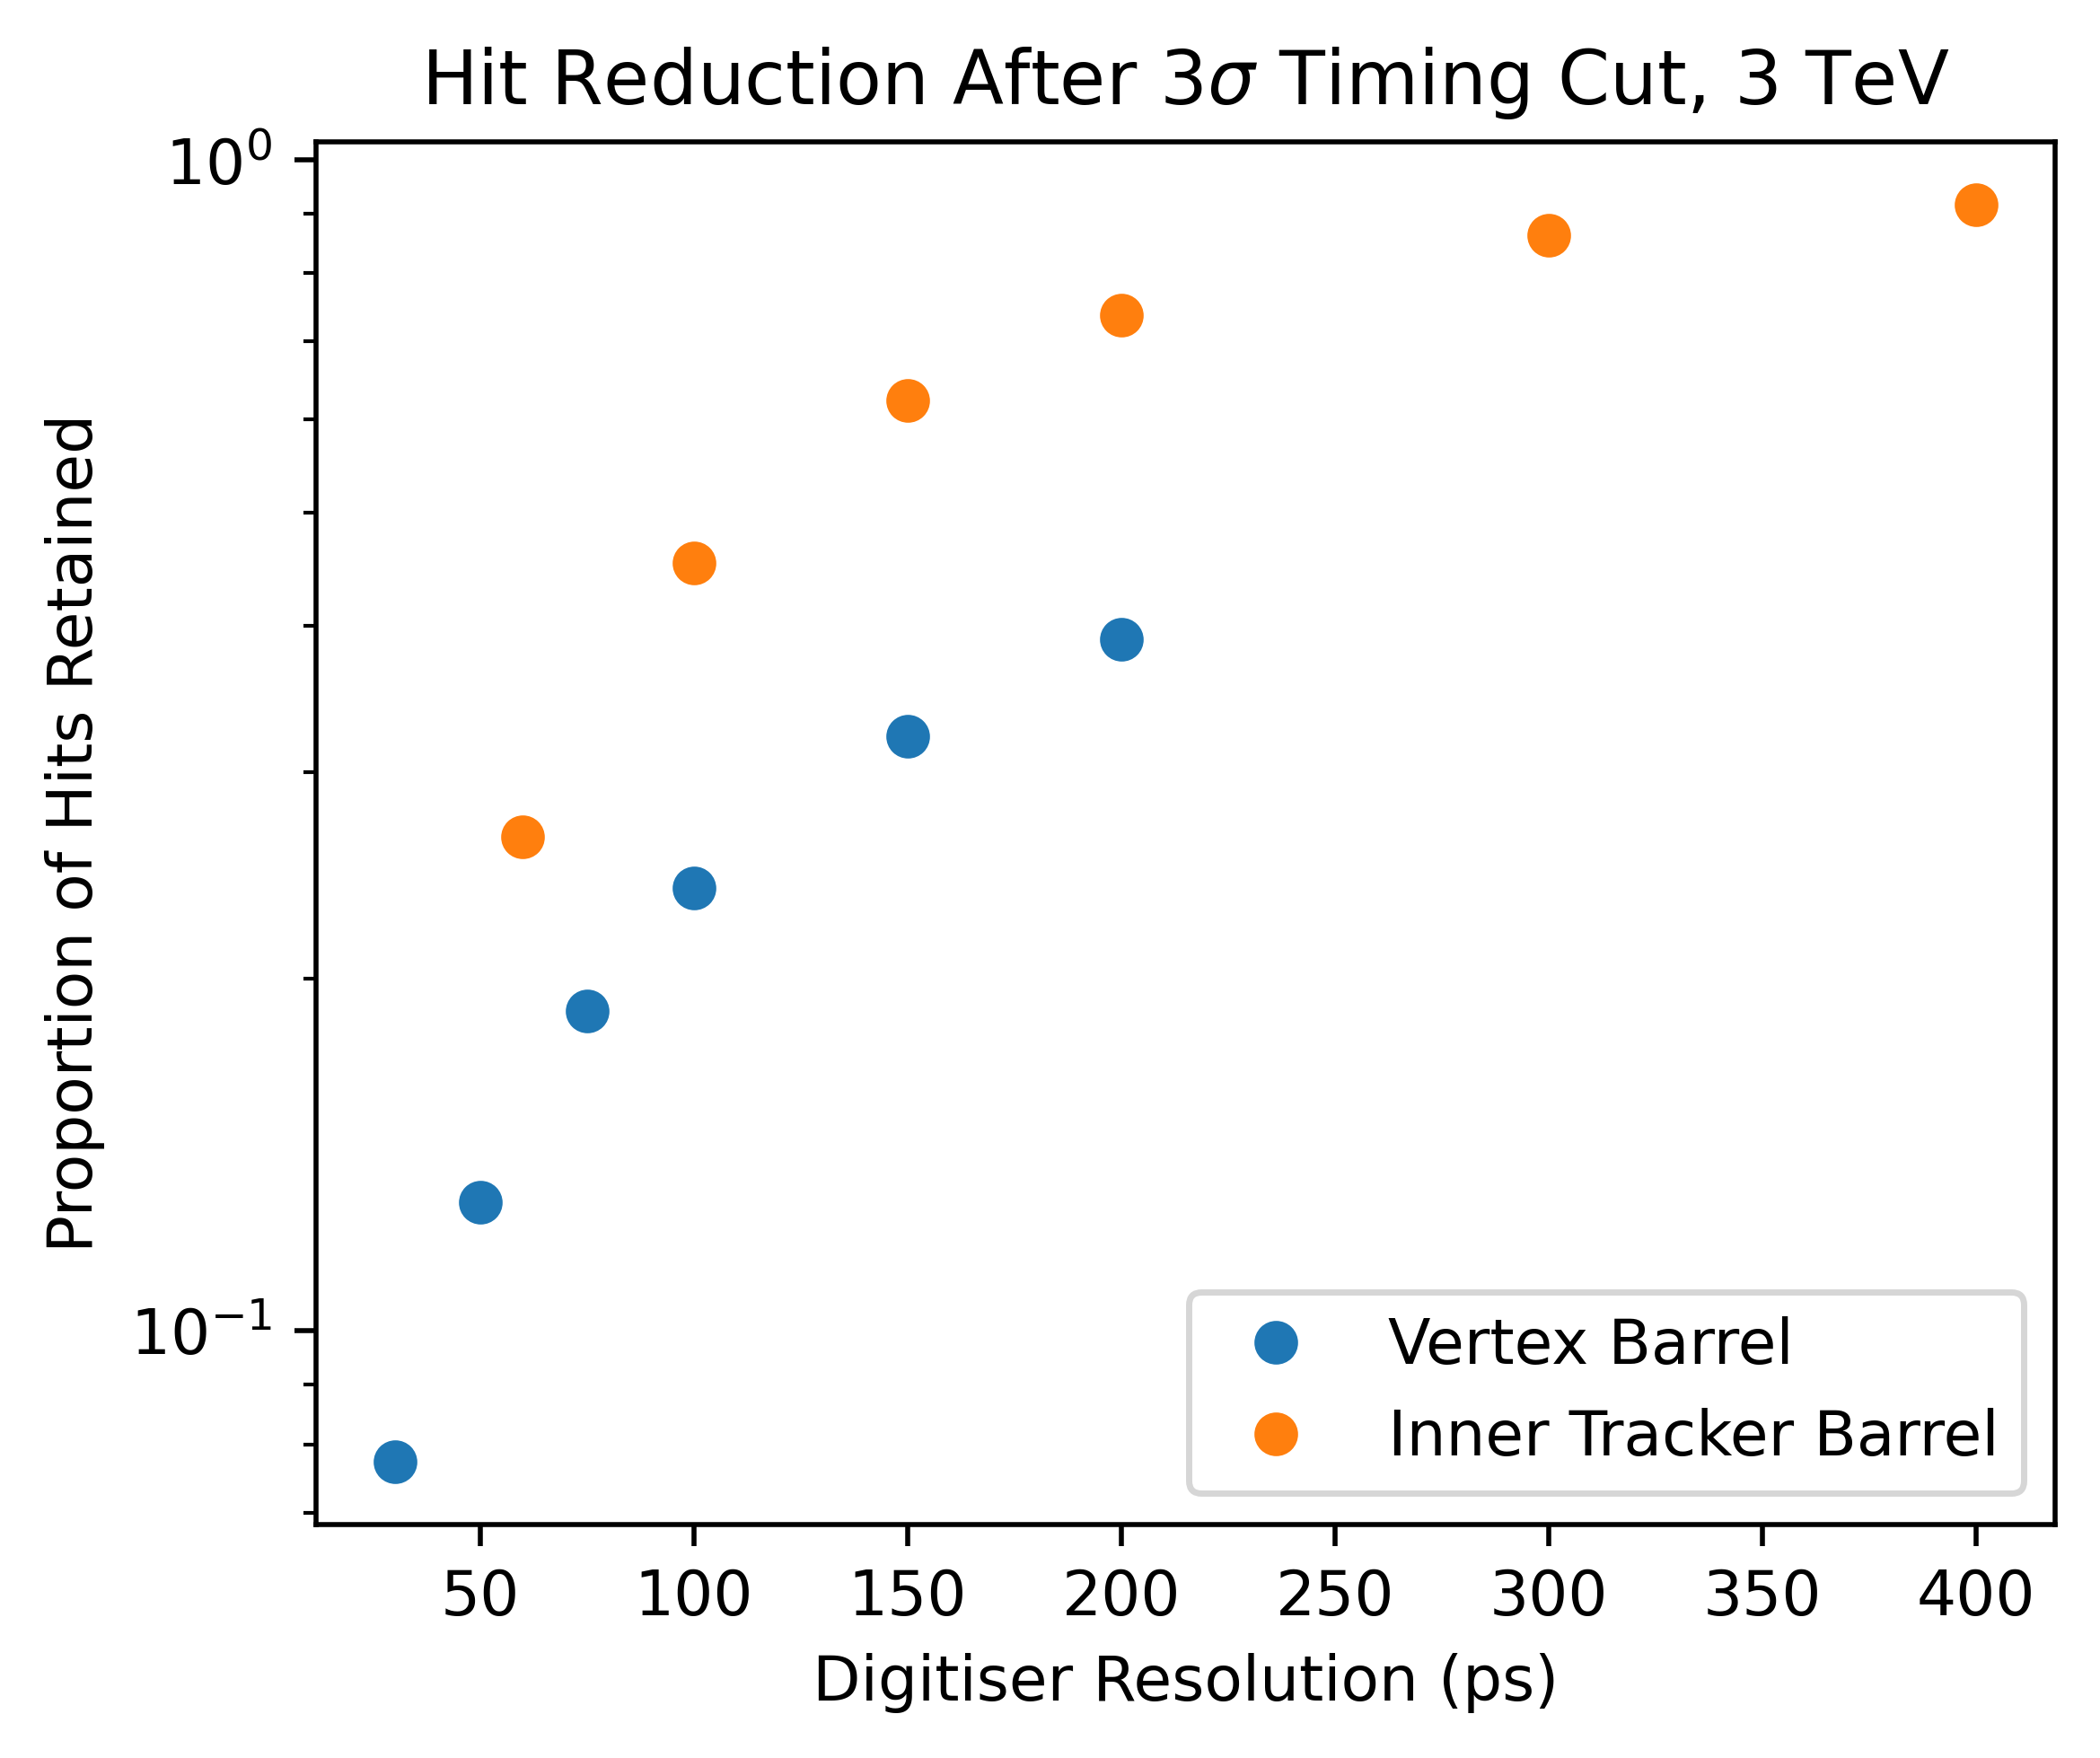

In [11]:
times = [30,50,75,100,150,200]
reduction_vx = [vx_tothits[i][1]/vx_tothits[i][0] for i in range(len(times))]
reduction_it = [it_tothits[i][1]/it_tothits[i][0] for i in range(len(times))]
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4),dpi=500)
plt.plot(times,reduction_vx,'o',label='Vertex Barrel')
plt.plot([times[i]*2 for i in range(len(times))],reduction_it,'o',label='Inner Tracker Barrel')
plt.xlabel("Digitiser Resolution (ps)")
plt.title(r"Hit Reduction After 3$\sigma$ Timing Cut, 3 TeV")
plt.ylabel("Proportion of Hits Retained")
plt.legend()
plt.yscale('log')
plt.savefig("/Users/chris/Desktop/MC/plots/digi_timing_studies/reductionfactorvstimereso_log.png")